In [19]:
import pathlib

import torch
import torchvision
import torchvision.transforms.v2 as transforms_v2
import pandas as pd
import numpy as np
import sklearn


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
# Training pipeline
transformations = [
    # Conversion to float32 image tensor
    transforms_v2.ToImage(),
    transforms_v2.ToDtype(torch.float32, scale=True),
]

loading_pipeline = transforms_v2.Compose(transformations)

In [8]:
class_names = [f"{i}" for i in range(10)]
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [9]:
# Target transformation
def target_transform(y):
    y = torch.tensor(y)
    y = torch.nn.functional.one_hot(y, len(class_names))
    y = y.type(torch.float32)

    return y


# On vérifie que la fonction convertit correctement l'étiquette en one-hot
target_transform(7)

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [13]:
train_dataset_full = torchvision.datasets.MNIST(
    "mnist",
    train=True,
    download=True,
    transform=loading_pipeline,
    target_transform=target_transform,
)


test_dataset = torchvision.datasets.MNIST(
    "mnist",
    train=False,
    download=True,
    transform=loading_pipeline,
    target_transform=target_transform,
)

100.0%
100.0%
100.0%
100.0%


In [14]:
# Séparation du dataset d'entraînement et de validation
val_dataset, train_dataset = torch.utils.data.random_split(
    train_dataset_full, [5000, 55000], generator=torch.Generator().manual_seed(4567890)
)

print(f"Nombre d'images d'entraînement: {len(train_dataset)}")
print(f"Nombre d'images de validation: {len(val_dataset)}")
print(f"Nombre d'images de test: {len(test_dataset)}")

Nombre d'images d'entraînement: 55000
Nombre d'images de validation: 5000
Nombre d'images de test: 10000


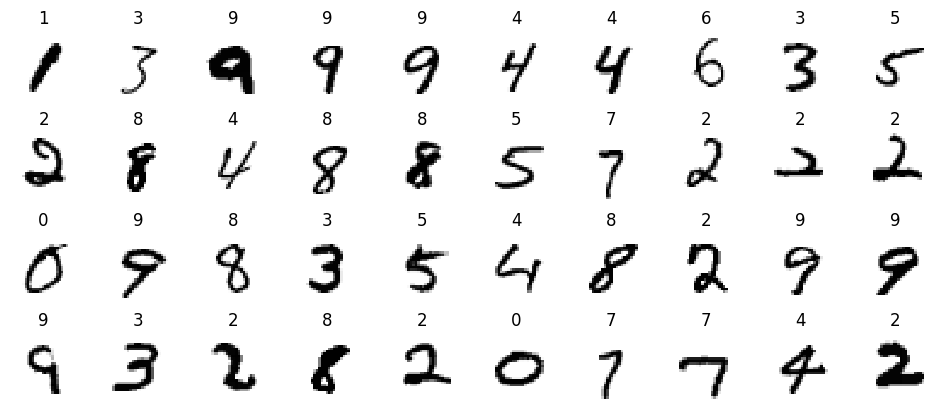

In [50]:
import matplotlib.pyplot as plt

n_rows = 4
n_cols = 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.2, n_rows * 1.2))

for index in range(n_rows * n_cols):
    ax = axes.flatten()[index]

    image, label = train_dataset[index]

    ax.imshow(image[0], cmap="binary", interpolation="nearest")
    ax.axis("off")
    ax.set_title(class_names[torch.argmax(label)], fontsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [16]:
# Dataset and data loader for pytorch
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

X_batch, y_batch = next(iter(train_loader))
print(X_batch.shape, y_batch.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32, 10])


In [17]:
transformations = [transforms_v2.Normalize(mean=[0.5], std=[0.25])]

normalize_pipeline = transforms_v2.Compose(transformations)

In [2]:
import time
import numpy as np
import pandas as pd
import torch


# Training function
def train_model(
    model,
    train_dataset,
    val_dataset,
    criterion,
    optimizer,
    epochs=10,
    device=None,
    verbose=True,
    num_workers=4,
    batch_size=32,
    transform=None,
):
    """Train a pytorch model

    Parameters
    ----------
    model : torch.nn.Module
        The model to be trained
    train_dataset : torch.utils.data.Dataset
        The dataset from which the model is trained
    val_dataset : torch.utils.data.Dataset
        The dataset that is evaluated at each epoch to follow the training process
    criterion : torch.nn.Module
        The module that computes the training loss (e.g. CrossEntropyLoss)
    optimizer : torch.optim.Optimizer
        The optimizer that is used for model training
    epochs : int, default: 10
        The number of epochs that are used to train the model
    device : torch.device, default: None
        The device onto which the model is trained
    verbose : bool, default: True
        Whether a summary of the training process is printed at each epoch or not.
    num_workers : int, default: 4
        Number of workers to use for loading training and validation data.
    batch_size: int, default: 32
        The number of data points to load with each batch.
    transform: torchvision.transforms.v2.?, default: None
        If not ``None``, the transformation is applied to the data of each batch before
        sending it to the model.

    Returns
    -------
    pandas.DataFrame
        A dataframe containing the average training and validation loss at each epoch,
        and the model accuracy on the training and validation data.

    """
    # Definition of data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    train_loss_array = np.zeros(epochs)
    val_loss_array = np.zeros(epochs)
    train_accuracy_array = np.zeros(epochs)
    val_accuracy_array = np.zeros(epochs)

    # Start time counter
    start_time = time.perf_counter()

    # Iteration over the epochs
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct = 0.0

        for X_batch, y_batch in train_loader:
            # Compute loss
            if device is not None:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

            if transform is not None:
                X_batch = transform(X_batch)

            optimizer.zero_grad()
            y_pred = model(X_batch)  # Logits
            loss = criterion(y_pred, y_batch)  # Compute loss
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Compute number of correct images
            predicted = torch.argmax(y_pred, axis=1)
            expected = torch.argmax(y_batch, axis=1)
            correct += (predicted == expected).sum()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct / len(train_dataset)

        train_loss_array[epoch] = avg_train_loss
        train_accuracy_array[epoch] = train_accuracy

        # Validation
        model.eval()

        val_loss = 0.0
        correct = 0.0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                if device is not None:
                    X_batch = X_batch.to(device)
                    y_batch = y_batch.to(device)

                if transform is not None:
                    X_batch = transform(X_batch)

                y_pred = model(X_batch)
                val_loss += criterion(y_pred, y_batch)

                predicted = torch.argmax(y_pred, axis=1)
                expected = torch.argmax(y_batch, axis=1)
                correct += (predicted == expected).sum()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / len(val_dataset)

        val_loss_array[epoch] = avg_val_loss
        val_accuracy_array[epoch] = val_accuracy

        # Printing a summary
        if verbose:
            print(
                f"Epoch [{epoch+1}/{epochs}] | "
                f"Train Loss: {avg_train_loss:.4f} | "
                f"Train Accuracy: {train_accuracy:.4f} | "
                f"Valid. Loss: {avg_val_loss:.4f} | "
                f"Valid. Accuracy: {val_accuracy:.4f} | "
            )

    # End time counter
    end_time = time.perf_counter()
    duration = end_time - start_time

    if verbose:
        print(f"Training time for {epochs} epochs: {duration:0.2f} seconds")

    # Regroup results into dataframe
    res = pd.DataFrame(
        {
            "train_loss": train_loss_array,
            "val_loss": val_loss_array,
            "train_accuracy": train_accuracy_array,
            "val_accuracy": val_accuracy_array,
        }
    )

    return res

In [83]:
# Function to evaluate model
def eval_model(
    model,
    test_dataset,
    criterion,
    device=None,
    verbose=True,
    num_workers=4,
    batch_size=32,
    transform=None,
):
    """Evaluate a pytorch model on test data

    Parameters
    ----------
    model : torch.nn.Module
        The model to be tested
    test_dataset : torch.utils.data.Dataset
        The dataset onto which the model is tested
    criterion : torch.nn.Module
        The module that computes the test loss (e.g. CrossEntropyLoss)
    device : torch.device, default: None
        The device onto which the model is tested
    verbose : bool, default: True
        Whether a summary of the test is printed.
    num_workers : int, default: 4
        Number of workers to use for loading test data.
    batch_size: int, default: 32
        The number of data points to load with each batch.
    transform: torchvision.transforms.v2.?, default: None
        If not ``None``, the transformation is applied to the data of each batch before
        sending it to the model.

    Returns
    -------
    y_pred_full : torch.tensor
        1D tensor containing the predicted labels by the model for all test data
    y_exp_full : torch.tensor
        1D tensor containing the expected labels for all test data

    """
    # Load test data
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False
    )

    # Compute test accuracy
    model.eval()

    test_loss = 0.0
    correct = 0.0

    y_pred_full = []
    y_exp_full = []

    # Start time counter
    start_time = time.perf_counter()

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            if device is not None:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

            if transform is not None:
                X_batch = transform(X_batch)

            y_pred = model(X_batch)
            test_loss += criterion(y_pred, y_batch)

            predicted = torch.argmax(y_pred, axis=1)
            expected = torch.argmax(y_batch, axis=1)
            correct += (predicted == expected).sum()

            y_pred_full.append(predicted)
            y_exp_full.append(expected)

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct / len(test_dataset)

    y_pred_full = torch.concat(y_pred_full)
    y_exp_full = torch.concat(y_exp_full)

    # End time counter
    end_time = time.perf_counter()
    duration = end_time - start_time

    if verbose:
        print(f"Duration of evaluation on test data: {duration:0.2f} seconds")

    if verbose:
        print(
            f"Test Loss: {avg_test_loss:.4f} | "
            f"Test Accuracy: {test_accuracy:.4f} | "
        )

    return y_pred_full, y_exp_full

In [20]:
import matplotlib.pyplot as plt

plt.rcParams["axes.autolimit_mode"] = "round_numbers"

def plot_epoch_learning_curve(train_results, loss_lim=(0, 0.5), acc_lim=(75, 100)):
    """Create a learning curve from epoch data

    Parameters
    ----------
    train_results : pandas.DataFrame
        A dataframe containing the average training and validation loss at each epoch,
        and the model accuracy on the training and validation data.
    loss_lim : tuple, default: (0, 0.5)
        Limits of the y-axis for the training and validation loss.
    acc_lim : tuple, default: (75, 100)
        Limits of the y-axis for the model accuracy, in percentages.

    Returns
    -------
    matplotlib.Figure
        Figure containing the training and validation loss (left) and the model accuracy
        on training and validation data (right).

    """
    fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))

    # Loss
    ax = axes[0]
    ax.plot(train_results["train_loss"], marker=".", label="Average train loss")
    ax.plot(train_results["val_loss"], marker=".", label="Average validation loss")

    ax.legend(loc="upper right")

    ax.set_ylim(*loss_lim)
    ax.set_xlim(0, len(train_results))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")

    ax.set_title("Average model loss")

    # Accuracy
    ax = axes[1]
    ax.plot(100 * train_results["train_accuracy"], marker=".", label="Train accuracy")
    ax.plot(
        100 * train_results["val_accuracy"], marker=".", label="Validation accuracy"
    )

    ax.legend(loc="lower right")

    ax.set_ylim(*acc_lim)
    ax.set_xlim(0, len(train_results))
    ax.set_ylabel("Accuracy (%)")
    ax.set_xlabel("Epochs")

    ax.set_title("Model accuracy")

    return fig

In [72]:
import sklearn

# Fonction pour le calcul de la matrice de confusion
def compute_confusion_matrix(y_true, y_pred, classes, abreviations=None):
    """Compute the confusion matrix and performance metrics

    This function computes the confusion matrix and performance measures such as
    recall, precision and accuracy. The confusion matrix and the performance metrics
    are written in a pandas DataFrame.

    Parameters
    ----------
    y_true : numpy.ndarray
        Array containing the true numeric classes from the data.
    y_pred : numpy.ndarray
        Array containing the predicted numeric classes by the model.
    classes : list, numpy.ndarray
        List of labels for the classes of the data.capitalize
    abreviations : list, numpy.ndarray, default: None
        List of abreviations for the classes to use as table columns. If None, use the
        classes also for the columns.

    Returns
    -------
    pandas.DataFrame
        Dataframe containing the confusion matrix and performance metrics.

    """
    if abreviations is None:
        abreviations = classes

    # Compute confusion matrix
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

    # Diagonal range index
    idx = np.arange(confusion_matrix.shape[0])

    # Recall
    recall = confusion_matrix[idx, idx] / confusion_matrix.sum(axis=1)

    # Precision
    precision = confusion_matrix[idx, idx] / confusion_matrix.sum(axis=0)

    # Accuracy
    accuracy = confusion_matrix[idx, idx].sum() / confusion_matrix.sum()

    # Creating dataframe
    columns = list(abreviations) + ["Recall"]
    rows = list(classes) + ["Precision"]
    df = pd.DataFrame(np.nan, index=rows, columns=columns)
    df.loc[classes, abreviations] = confusion_matrix
    df.loc[classes, "Recall"] = recall
    df.loc["Precision", abreviations] = precision
    df.loc["Precision", "Recall"] = accuracy

    return df

In [73]:
# Fonction pour l'affichage de la matrice de confusion
def display_confusion_matrix(confusion_matrix, origin="upper", title=None):
    """Display the confusion matrix in a matplotlib figure

    This function uses matplotlib to display the confusion matrix with the
    :func:`matplotlib.pyplot.imshow` function.

    Parameters
    ----------
    confusion_matrix : pandas.DataFrame
        Dataframe containing the confusion matrix and the performance metrics such as
        recall, precision and accuracy. The `confusion_matrix` is generally returned
        from the `compute_confusion_matrix` function of this notebook.

    origin : {'upper', 'lower'}, default: 'upper'
        Whether to display the confusion matrix using a upper left origin or a lower
        left origin.

    Returns
    -------
    matplotlib.figure.Figure
        The matplotlib figure object that is created using this function

    """
    classes = confusion_matrix.columns[:-1]

    fig, ax = plt.subplots(figsize=(7, 7), layout="constrained")

    if origin == "upper":
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position("top")

    img = ax.imshow(
        confusion_matrix.values[:-1, :-1], cmap="Blues", origin=origin, vmin=0
    )

    ax.set_yticks(np.arange(len(classes)), labels=classes)
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)

    # Adding labels
    ax.set_ylabel("True class", size=16)
    ax.set_xlabel("Predicted class", size=16)

    # Adding test
    for i in range(len(classes)):
        for j in range(len(classes)):
            value = confusion_matrix.values[i, j]
            vmax = img.get_clim()[1]
            color = "w" if value > 0.5 * vmax else "k"
            ax.text(
                j,
                i,
                f"{value:0.0f}",
                ha="center",
                va="center",
                color=color,
            )

    # Adding precision and recall
    for i in range(len(classes)):
        # Precision
        ax.text(
            -0.7,
            len(classes),
            "PRECISION",
            ha="right",
            va="center",
            color="k",
            fontweight="bold",
        )

        ax.text(
            i,
            len(classes),
            f"{100*confusion_matrix.iloc[-1, i]:0.1f}%",
            ha="center",
            va="center",
            color="k",
        )

        # Recall
        ax.text(
            len(classes),
            -0.7,
            "RECALL",
            ha="center",
            va="bottom" if origin == "upper" else "top",
            color="k",
            rotation=90,
            fontweight="bold",
        )

        ax.text(
            len(classes),
            i,
            f"{100*confusion_matrix.iloc[i, -1]:0.1f}%",
            ha="center",
            va="center",
            color="k",
        )

        # Accuracy
        ax.text(
            len(classes),
            len(classes),
            f"{100*confusion_matrix.iloc[-1,-1]:0.1f}%",
            ha="center",
            va="center",
            color="k",
            fontweight="bold",
        )

    # Set title
    if title is not None:
        fig.suptitle(title, fontsize=18, fontweight="bold")

    return fig

In [54]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # 1r bloc
        self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 16, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )

        # 2e bloc
        self.block2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )

        # PMC
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(1568, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256, 10),
        )

        # Softmax -- unused
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)

        return x

In [69]:
model = ConvNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [70]:
results = pathlib.Path("results")
results.mkdir(exist_ok=True)

In [ ]:
# Train and save model
pathlib.Path("mnist_models").mkdir(exist_ok=True)
train_results = train_model(
    model,
    train_dataset,
    val_dataset,
    criterion,
    optimizer,
    epochs=50,
    device=device,
    batch_size=32,
    transform=normalize_pipeline,
)

train_results.to_csv("results/train_results_mnist.csv")
torch.save(model.state_dict(), "results/convnet_mnist.pt")

Epoch [1/50] | Train Loss: 0.9710 | Train Accuracy: 0.7131 | Valid. Loss: 0.3209 | Valid. Accuracy: 0.9044 | 
Epoch [2/50] | Train Loss: 0.3188 | Train Accuracy: 0.9049 | Valid. Loss: 0.2135 | Valid. Accuracy: 0.9364 | 
Epoch [3/50] | Train Loss: 0.2291 | Train Accuracy: 0.9305 | Valid. Loss: 0.1597 | Valid. Accuracy: 0.9520 | 
Epoch [4/50] | Train Loss: 0.1833 | Train Accuracy: 0.9449 | Valid. Loss: 0.1293 | Valid. Accuracy: 0.9590 | 
Epoch [5/50] | Train Loss: 0.1527 | Train Accuracy: 0.9541 | Valid. Loss: 0.1152 | Valid. Accuracy: 0.9638 | 
Epoch [6/50] | Train Loss: 0.1329 | Train Accuracy: 0.9594 | Valid. Loss: 0.1034 | Valid. Accuracy: 0.9690 | 
Epoch [7/50] | Train Loss: 0.1192 | Train Accuracy: 0.9635 | Valid. Loss: 0.0892 | Valid. Accuracy: 0.9728 | 
Epoch [8/50] | Train Loss: 0.1052 | Train Accuracy: 0.9677 | Valid. Loss: 0.0827 | Valid. Accuracy: 0.9730 | 
Epoch [9/50] | Train Loss: 0.0968 | Train Accuracy: 0.9699 | Valid. Loss: 0.0806 | Valid. Accuracy: 0.9718 | 
Epoch [10/

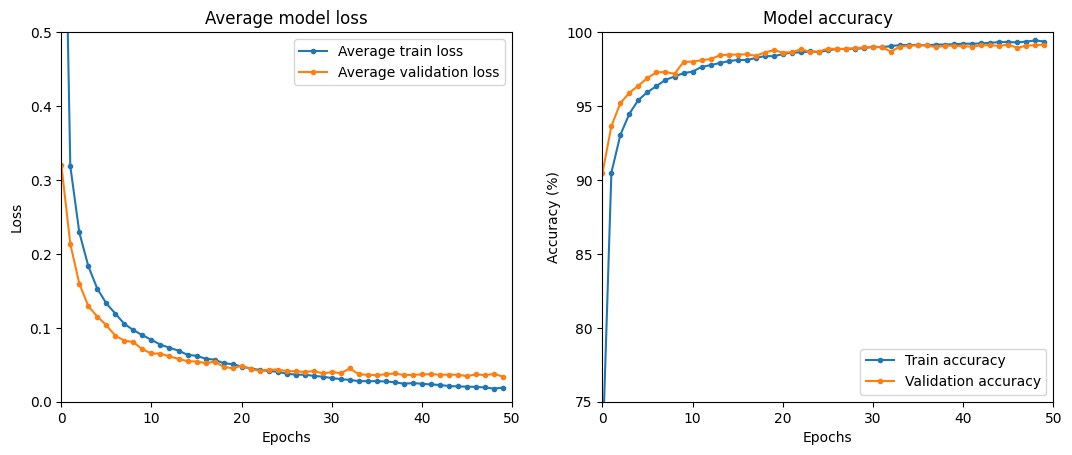

In [116]:
train_results = pd.read_csv("results/train_results_mnist.csv", index_col=0)
fig = plot_epoch_learning_curve(train_results)
fig.savefig("results/learning_curve_mnist.png", dpi=300, bbox_inches="tight")

Duration of evaluation on test data: 0.49 seconds
Test Loss: 0.0274 | Test Accuracy: 0.9910 | 


,0,1,2,3,4,5,6,7,8,9,Recall
0,974.000000,0.000000,1.000000,0.000000,0.000000,0.00000,1.000000,1.000000,3.000000,0.000000,0.993878
1,0.000000,1132.000000,1.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.997357
2,0.000000,0.000000,1029.000000,0.000000,0.000000,0.00000,0.000000,3.000000,0.000000,0.000000,0.997093
3,0.000000,0.000000,0.000000,1004.000000,0.000000,3.00000,0.000000,0.000000,1.000000,2.000000,0.994059
4,0.000000,0.000000,1.000000,0.000000,971.000000,0.00000,2.000000,0.000000,1.000000,7.000000,0.988798
5,2.000000,0.000000,0.000000,6.000000,0.000000,879.00000,1.000000,1.000000,1.000000,2.000000,0.985426
6,4.000000,2.000000,0.000000,0.000000,2.000000,1.00000,949.000000,0.000000,0.000000,0.000000,0.990605
7,0.000000,1.000000,6.000000,1.000000,0.000000,0.00000,0.000000,1016.000000,1.000000,3.000000,0.988327
8,3.000000,0.000000,2.000000,2.000000,0.000000,0.00000,0.000000,2.000000,961.000000,4.000000,0.986653
9,1.000000,2.000000,0.000000,1.000000,5.000000,2.00000,0.000000,2.000000,1.000000,995.000000,0.986125


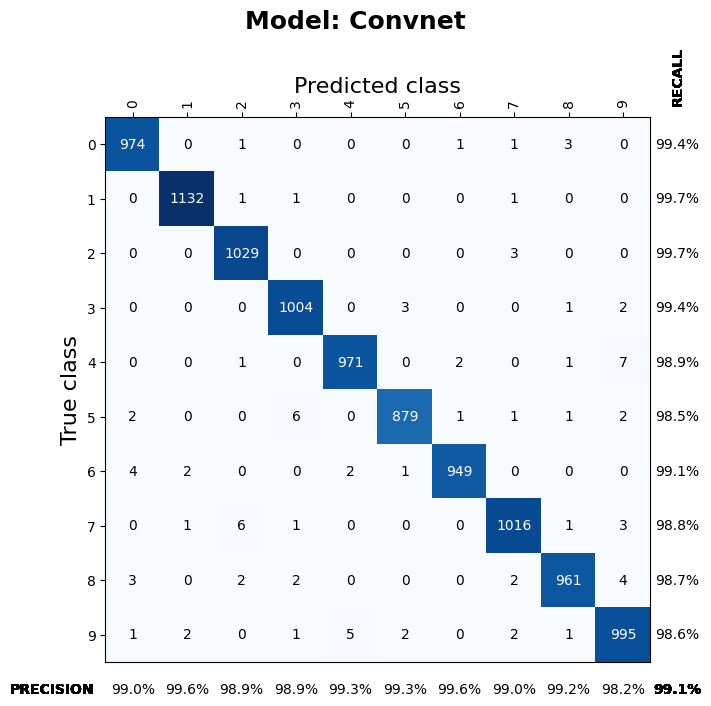

In [ ]:
# On importe les poids du modèle
model.load_state_dict(
    torch.load(
        "results/convnet_mnist.pt",
        map_location=device,
        weights_only=True,
    )
)

# Validation sur les données de test
y_pred, y_test = eval_model(
    model, test_dataset, criterion, device, transform=normalize_pipeline
)
y_pred = y_pred.cpu()
y_test = y_test.cpu()

# Matrice de confusion
confusion_matrix = compute_confusion_matrix(y_test, y_pred, class_names)
confusion_matrix.to_csv("results/confusion_matrix_mnist.csv")

fig = display_confusion_matrix(confusion_matrix, title="Model: Convnet")
fig.savefig("results/confusion_matrix_mnist.png", dpi=300)

# Affichage en tableau
confusion_matrix

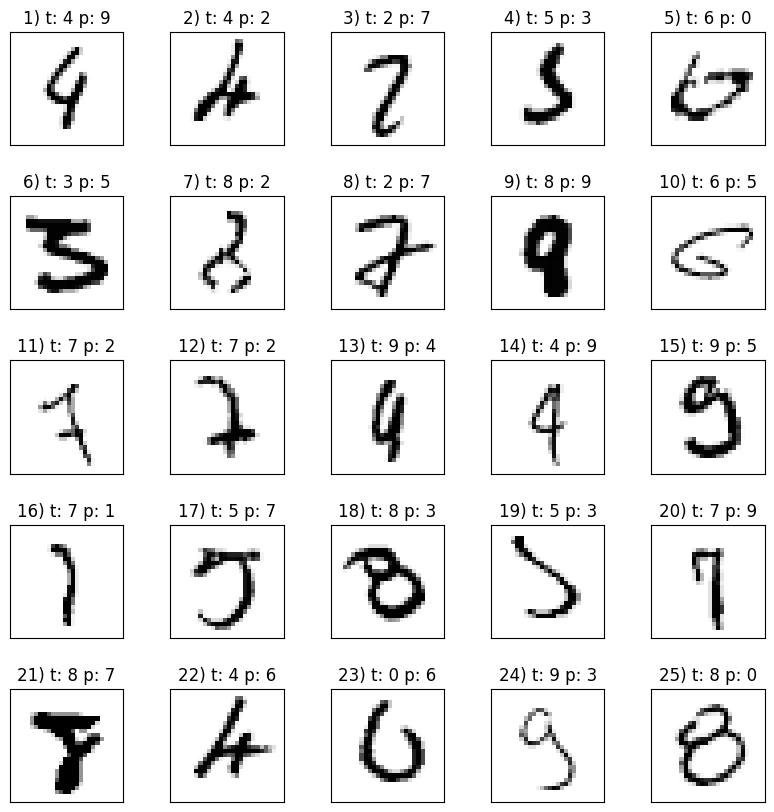

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)
X_test, _ = next(iter(test_loader))

miscl_img = X_test[y_test != y_pred][:25]
correct_lab = y_test[y_test != y_pred][:25]
miscl_lab = y_pred[y_test != y_pred][:25]

fig, axes = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(10, 10))
fig.subplots_adjust(hspace=0.45)
axes = axes.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    axes[i].imshow(img, cmap="Greys", interpolation="nearest")
    axes[i].set_title(f"{i+1}) t: {class_names[correct_lab[i]]} p: {class_names[miscl_lab[i]]}")

axes[0].set_xticks([])
axes[0].set_yticks([])

fig.savefig("./results/misclassification_mnist.png", dpi=300, bbox_inches="tight")

# Fashion MNIST

In [104]:
train_dataset_full = torchvision.datasets.FashionMNIST(
    "fashion_mnist",
    train=True,
    download=True,
    transform=loading_pipeline,
    target_transform=target_transform,
)


test_dataset = torchvision.datasets.FashionMNIST(
    "fashion_mnist",
    train=False,
    download=True,
    transform=loading_pipeline,
    target_transform=target_transform,
)

In [105]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [107]:
# Séparation du dataset d'entraînement et de validation
val_dataset, train_dataset = torch.utils.data.random_split(
    train_dataset_full, [5000, 55000], generator=torch.Generator().manual_seed(4567890)
)

print(f"Nombre d'images d'entraînement: {len(train_dataset)}")
print(f"Nombre d'images de validation: {len(val_dataset)}")
print(f"Nombre d'images de test: {len(test_dataset)}")

Nombre d'images d'entraînement: 55000
Nombre d'images de validation: 5000
Nombre d'images de test: 10000


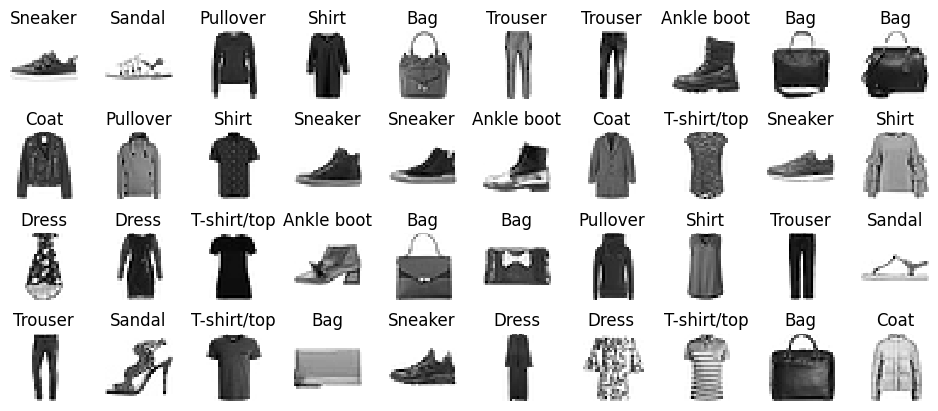

In [108]:
import matplotlib.pyplot as plt

n_rows = 4
n_cols = 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.2, n_rows * 1.2))

for index in range(n_rows * n_cols):
    ax = axes.flatten()[index]

    image, label = train_dataset[index]

    ax.imshow(image[0], cmap="binary", interpolation="nearest")
    ax.axis("off")
    ax.set_title(class_names[torch.argmax(label)], fontsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [127]:
model = ConvNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [128]:
results = pathlib.Path("results")
results.mkdir(exist_ok=True)

In [129]:
# Train and save model
pathlib.Path("mnist_models").mkdir(exist_ok=True)
train_results = train_model(
    model,
    train_dataset,
    val_dataset,
    criterion,
    optimizer,
    epochs=50,
    device=device,
    batch_size=32,
    transform=normalize_pipeline,
)

train_results.to_csv("results/train_results_fashion_mnist.csv")
torch.save(model.state_dict(), "results/convnet_fashion_mnist.pt")

Epoch [1/50] | Train Loss: 1.0308 | Train Accuracy: 0.6449 | Valid. Loss: 0.5921 | Valid. Accuracy: 0.7892 | 
Epoch [2/50] | Train Loss: 0.6192 | Train Accuracy: 0.7729 | Valid. Loss: 0.4974 | Valid. Accuracy: 0.8214 | 
Epoch [3/50] | Train Loss: 0.5429 | Train Accuracy: 0.8008 | Valid. Loss: 0.4487 | Valid. Accuracy: 0.8376 | 
Epoch [4/50] | Train Loss: 0.4985 | Train Accuracy: 0.8189 | Valid. Loss: 0.4195 | Valid. Accuracy: 0.8520 | 
Epoch [5/50] | Train Loss: 0.4646 | Train Accuracy: 0.8324 | Valid. Loss: 0.4045 | Valid. Accuracy: 0.8552 | 
Epoch [6/50] | Train Loss: 0.4441 | Train Accuracy: 0.8399 | Valid. Loss: 0.3797 | Valid. Accuracy: 0.8648 | 
Epoch [7/50] | Train Loss: 0.4274 | Train Accuracy: 0.8482 | Valid. Loss: 0.3659 | Valid. Accuracy: 0.8702 | 
Epoch [8/50] | Train Loss: 0.4110 | Train Accuracy: 0.8525 | Valid. Loss: 0.3534 | Valid. Accuracy: 0.8710 | 
Epoch [9/50] | Train Loss: 0.3967 | Train Accuracy: 0.8573 | Valid. Loss: 0.3505 | Valid. Accuracy: 0.8748 | 
Epoch [10/

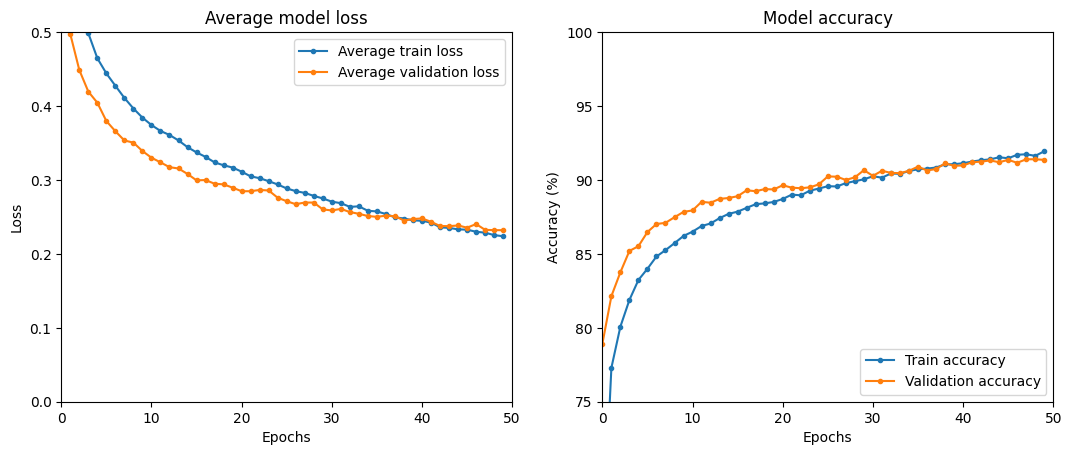

In [133]:
train_results = pd.read_csv("results/train_results_fashion_mnist.csv", index_col=0)
fig = plot_epoch_learning_curve(train_results)
fig.savefig("results/learning_curve_fashion_mnist.png", dpi=300, bbox_inches="tight")

Duration of evaluation on test data: 0.40 seconds
Test Loss: 0.2547 | Test Accuracy: 0.9085 | 


,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot,Recall
T-shirt/top,824.000000,0.000000,11.000000,30.000000,5.000000,2.000000,121.00000,0.000000,7.00000,0.000000,0.8240
Trouser,0.000000,983.000000,0.000000,10.000000,3.000000,0.000000,3.00000,0.000000,1.00000,0.000000,0.9830
Pullover,9.000000,1.000000,841.000000,8.000000,71.000000,0.000000,67.00000,0.000000,3.00000,0.000000,0.8410
Dress,11.000000,6.000000,7.000000,922.000000,20.000000,0.000000,32.00000,0.000000,2.00000,0.000000,0.9220
Coat,0.000000,1.000000,40.000000,39.000000,873.000000,0.000000,47.00000,0.000000,0.00000,0.000000,0.8730
Sandal,0.000000,0.000000,0.000000,0.000000,0.000000,981.000000,0.00000,14.000000,0.00000,5.000000,0.9810
Shirt,93.000000,2.000000,47.000000,26.000000,76.000000,0.000000,749.00000,0.000000,7.00000,0.000000,0.7490
Sneaker,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.00000,968.000000,0.00000,24.000000,0.9680
Bag,3.000000,1.000000,1.000000,5.000000,1.000000,2.000000,3.00000,5.000000,979.00000,0.000000,0.9790
Ankle boot,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.00000,30.000000,0.00000,965.000000,0.9650


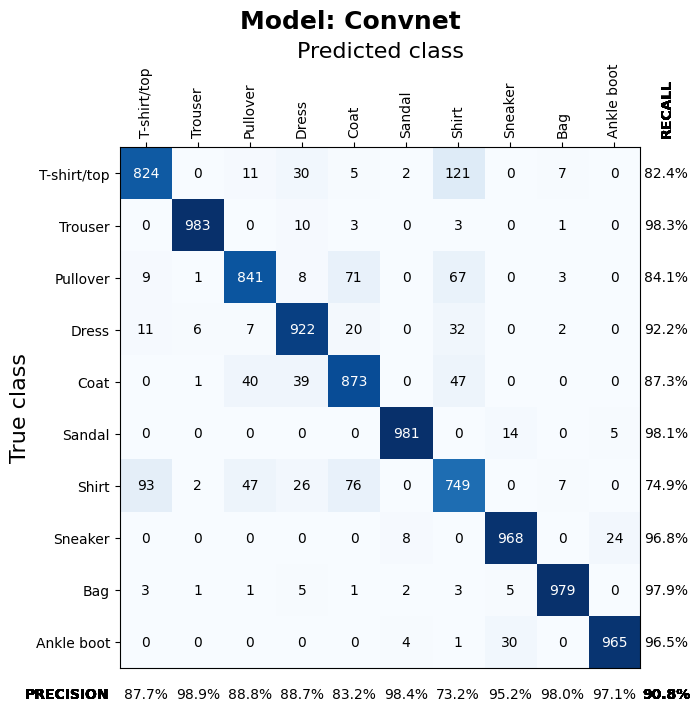

In [134]:
# On importe les poids du modèle
model.load_state_dict(
    torch.load(
        "results/convnet_fashion_mnist.pt",
        map_location=device,
        weights_only=True,
    )
)

# Validation sur les données de test
y_pred, y_test = eval_model(
    model, test_dataset, criterion, device, transform=normalize_pipeline
)
y_pred = y_pred.cpu()
y_test = y_test.cpu()

# Matrice de confusion
confusion_matrix = compute_confusion_matrix(y_test, y_pred, class_names)
confusion_matrix.to_csv("results/confusion_matrix_fashion_mnist.csv")

fig = display_confusion_matrix(confusion_matrix, title="Model: Convnet")
fig.savefig("results/confusion_matrix_fashion_mnist.png", dpi=300)

# Affichage en tableau
confusion_matrix

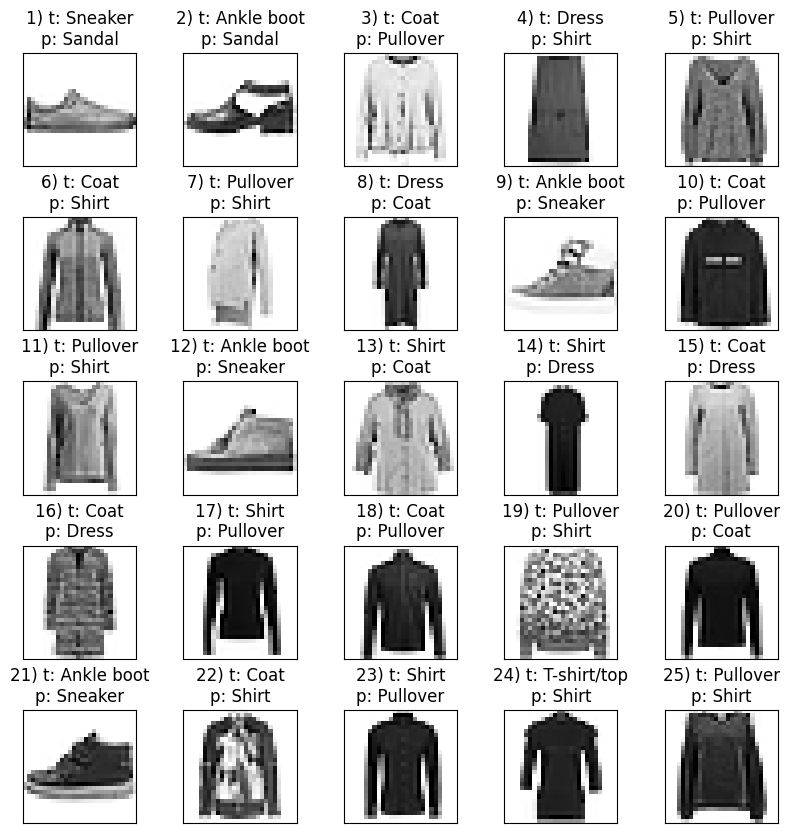

In [135]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)
X_test, _ = next(iter(test_loader))

miscl_img = X_test[y_test != y_pred][:25]
correct_lab = y_test[y_test != y_pred][:25]
miscl_lab = y_pred[y_test != y_pred][:25]

fig, axes = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(10, 10))
fig.subplots_adjust(hspace=0.45)
axes = axes.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    axes[i].imshow(img, cmap="Greys", interpolation="nearest")
    axes[i].set_title(f"{i+1}) t: {class_names[correct_lab[i]]}\np: {class_names[miscl_lab[i]]}")

axes[0].set_xticks([])
axes[0].set_yticks([])

fig.savefig("./results/misclassification.png", dpi=300, bbox_inches="tight")